Clustering GLM dropout scores from dff traces

In [1]:
import os
import time
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [2]:
from sklearn.cluster import SpectralClustering

In [3]:
import visual_behavior_glm.GLM_analysis_tools as gat

In [4]:
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

In [5]:
from visual_behavior.dimensionality_reduction.clustering import processing
from visual_behavior.dimensionality_reduction.clustering import plotting
import visual_behavior.dimensionality_reduction.clustering as vba_clust

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


# Get experiments and cells tables and limit to closest familiar and novel active

In [7]:
experiments_table = loading.get_platform_paper_experiment_table()
len(experiments_table)

1248

In [8]:
# limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)
print(len(experiments_table))
matched_experiments = experiments_table.index.values
cells_table = loading.get_cell_table()
print(len(cells_table.cell_specimen_id.unique()))
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)

402
28806
3921 cells in matched cells table


### get GLM output, filter and reshape

In [9]:
glm_version = '24_dff_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [10]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    
folder = '221107_clustering_dff_control'
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [11]:
features = processing.get_features_for_clustering()

In [12]:
#### This code is a bit janky but what I used to create feature matrix for dff across session normalized
### This code needs to be debugged because it errors at ".query" lines in glm repo. They can be commented out at your own risk.


# results_pivoted = vba_clust.get_glm_results_pivoted_for_clustering(glm_version='24_dff_all_L2_optimize_by_session',
#                                            model_output_type='adj_fraction_change_from_full',
#                                            across_sessions_normalized=True, save_dir=save_dir)

# columns = ['omissions_across', 'all-images_across',
#        'behavioral_across', 'task_across', 'cell_specimen_id', 'experience_level']
# results_pivoted_sel = results_pivoted[columns]
# results_pivoted_sel = results_pivoted_sel.rename(columns= {'all-images_across':'all-images', 'omissions_across':'omissions', 'behavioral_across':'behavioral', 'task_across':'task'})

# feature_matrix = vba_clust.pivot_df(results_pivoted_sel, dropna=True)
# feature_matrix.to_hdf(os.path.join(save_dir, 'feature_matrix.h5'), key = 'df')


In [13]:
filename = os.path.join(save_dir, 'feature_matrix.h5')
feature_matrix = pd.read_hdf(filename, key='df')

In [14]:
feature_matrix = feature_matrix.abs()
feature_matrix = feature_matrix[['all-images','omissions', 'behavioral', 'task']]
feature_matrix.head()

all-images                     omissions                      \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1   
cell_specimen_id                                                                
1086489847         0.004670  0.036437  0.001467  0.042185  0.012834  0.028176   
1086489860         0.000000  0.813781  0.000000  0.000000  0.195218  0.000000   
1086489891         0.007424  0.191590  0.000000  0.556917  0.189264  0.000000   
1086489976         0.683818  0.302982  0.458970  0.083192  0.137980  0.172733   
1086490002         0.661373  0.070753  0.164331  0.086036  0.003870  0.063254   

                 behavioral                          task                      
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1  
cell_specimen_id                                                               
1086489847         0.370910  0.031435  1.000000  0.002495  0.002662  0.006705  
1086489860         0.000000  0.000000  0.000000  0.000000  0.231648  0.000000  
1086489891         0.082477  0.055097  1.000000  0.003304  0.042500  0.030652  
1086489976         0.044653  0.007869  0.022193  0.000000  0.000000  0.000000  
1086490002         0.072155  0.001681  0.035327  0.000000  0.000503  0.050063

In [15]:
# get cell metadata for all cells in feature_matrix
cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
cell_metadata.head()

3921 cells in cell_metadata for feature_matrix


,ophys_experiment_id,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,...,layer,area_layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
1086551315,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,lower,VISp_lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086550804,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,lower,VISp_lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086541251,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,lower,VISp_lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086540341,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,lower,VISp_lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086539950,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,lower,VISp_lower,20181212,False,-1.0,True,True,False,False,Familiar 3


### plot feature matrix for each cre line

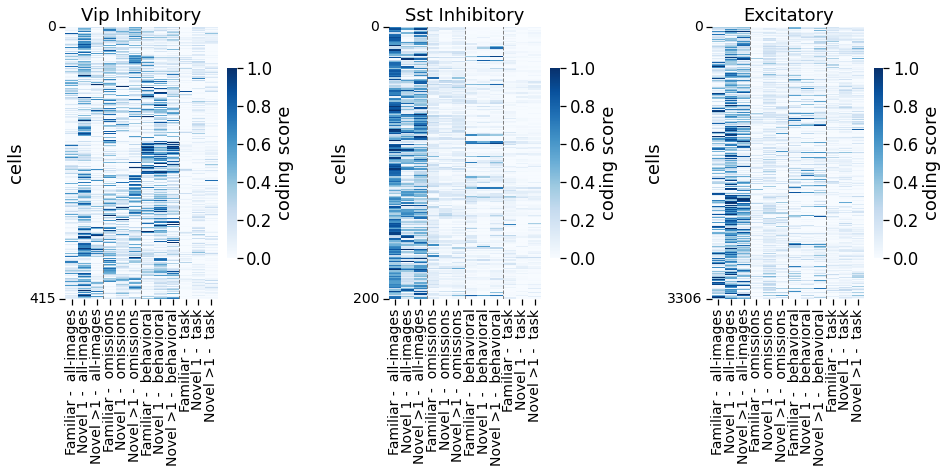

In [16]:
plotting.plot_feature_matrix_for_cre_lines(feature_matrix, cell_metadata, save_dir=base_dir, folder=folder)

### select  number of clusters

In [17]:
n_clusters_cre = {'Slc17a7-IRES2-Cre': 10,
                 'Sst-IRES-Cre': 5, 
                 'Vip-IRES-Cre':10}

In [18]:
from sklearn.cluster import SpectralClustering

In [19]:
cre_dfs = {}
eigenvalues_cre = {}
for cre_line in cre_lines:
    cre_ids = cell_metadata[cell_metadata.cre_line==cre_line].index.values
    cre_dfs[cre_line] = feature_matrix.loc[cre_ids]
    sc = SpectralClustering(n_clusters=2).fit(cre_dfs[cre_line])
    A = sc.affinity_matrix_
    eigenvalues, eigenvectors, nb_clusters = vba_clust.get_eigenDecomposition(A, max_n_clusters=25)
    eigenvalues_cre[cre_line] = eigenvalues
    

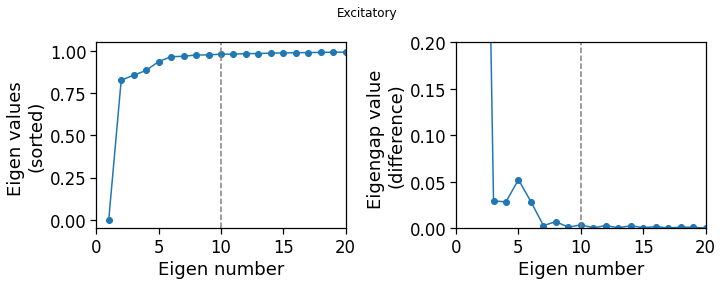

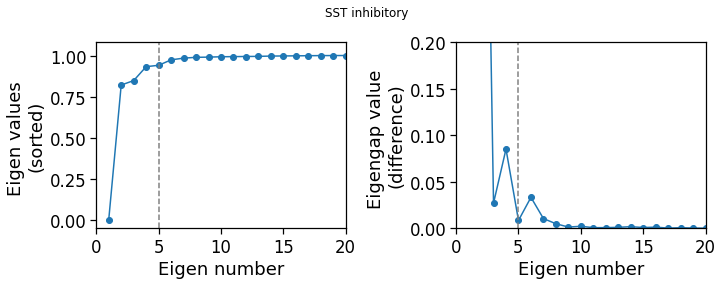

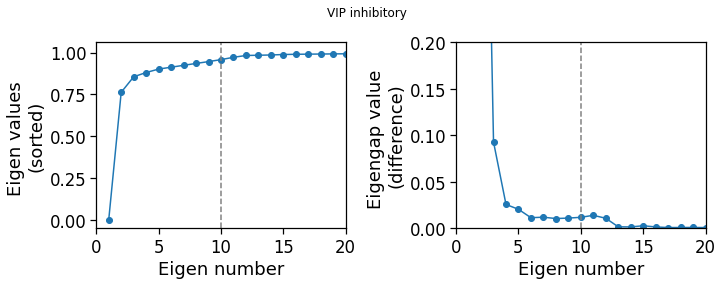

In [20]:
vba_clust.plot_eigengap_values(eigenvalues_cre, cre_lines, n_clusters_cre=n_clusters_cre,
                     save_dir=save_dir, folder='optimal_k')


In [21]:
coclustering_matrices = vba_clust.get_coclustering_matrix(glm_version, feature_matrix, cell_metadata, n_clusters_cre, save_dir, nboot=100)

loading file...
done.


### get cluster labels per cre line from Agglomerative clustering on co-clustering matrix

In [22]:
cluster_labels = processing.get_cluster_labels(coclustering_matrices, cell_metadata, n_clusters_cre, save_dir, load=False)
cluster_labels.head()

generating cluster labels from coclustering matrix
saving cluster_labels to \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_dff_all_L2_optimize_by_session\221107_clustering_dff_control\cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5


,labels,cell_specimen_id,cre_line,cluster_id
0,1,1086492406,Vip-IRES-Cre,2
1,5,1086492307,Vip-IRES-Cre,5
2,0,1086492221,Vip-IRES-Cre,1
3,8,1086492174,Vip-IRES-Cre,3
4,8,1086491936,Vip-IRES-Cre,3


#### merge cluster labels with cell metadata, remove small clusters, and add manual sort order

In [23]:
cluster_meta = processing.get_cluster_meta(cluster_labels, cell_metadata, feature_matrix, n_clusters_cre, save_dir, load=False)
cluster_meta.head()

generating cluster_meta
0 cells dropped total
adding within cluster correlation to cluster_meta


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


saving cluster_meta to \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_dff_all_L2_optimize_by_session\221107_clustering_dff_control\cluster_metadata_Vip_10_Sst_5_Slc17a7_10.h5


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['equipment_name', 'full_genotype', 'reporter_line', 'driver_line',
       'sex', 'cre_line', 'indicator', 'project_code', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'passive',
       'image_set', 'cell_type', 'depth', 'binned_depth', 'area_depth',
       'area_binned_depth', 'layer', 'area_layer', 'last_familiar_active',
       'second_novel_active', 'experience_exposure'],
      dtype='object')]

  encoding=encoding,


,cluster_id,labels,ophys_experiment_id,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,...,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure,original_cluster_id,within_cluster_correlation
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
1086492406,2,1,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,20181213,False,-1.0,True,True,False,False,Familiar 3,2,0.755245
1086492307,5,5,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,20181213,False,-1.0,True,True,False,False,Familiar 3,5,0.831007
1086492221,1,0,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,20181213,False,-1.0,True,True,False,False,Familiar 3,1,0.853147
1086492174,3,8,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,20181213,False,-1.0,True,True,False,False,Familiar 3,3,0.825175
1086491936,3,8,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,20181213,False,-1.0,True,True,False,False,Familiar 3,3,0.809108


### sort coclustering matrix by cluster ID / cluster size

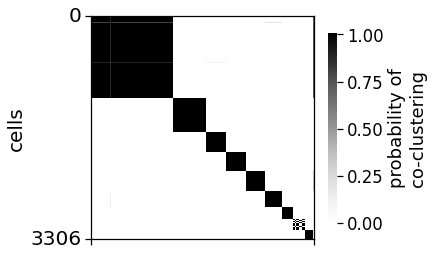

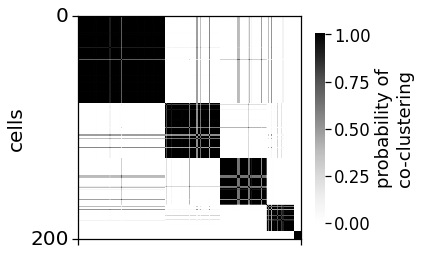

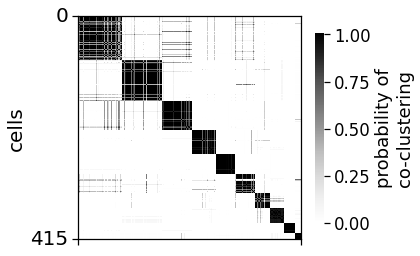

In [24]:
for cre_line in cre_lines: 
    plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_matrices, cluster_meta, cre_line, 
                                                    save_dir=save_dir, folder='', ax=None)

### plot average dropout scores for each cluster

### plot each cluster separately and save to single cell examples dir

In [25]:
cell_examples_dir = os.path.join(save_dir, 'matched_cell_examples')
if not os.path.exists(cell_examples_dir):
    os.mkdir(cell_examples_dir)

c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:693: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


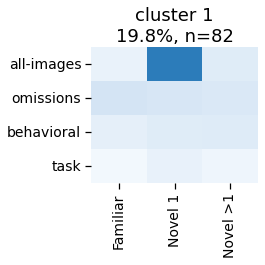

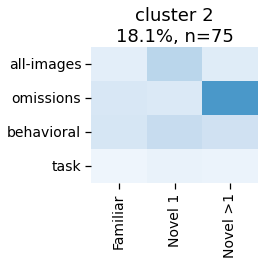

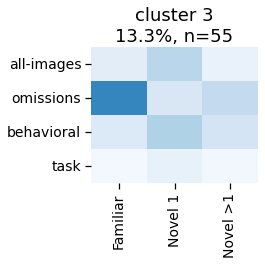

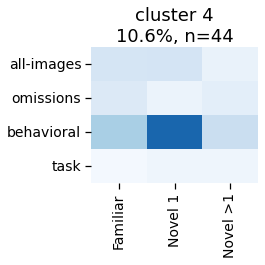

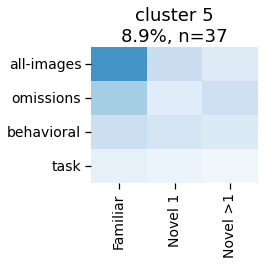

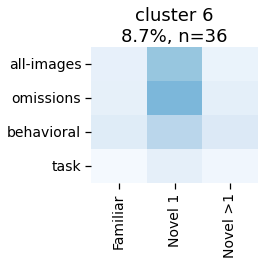

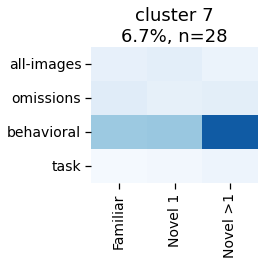

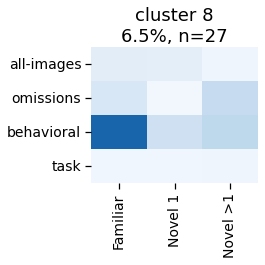

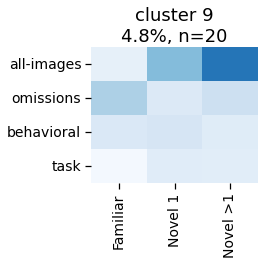

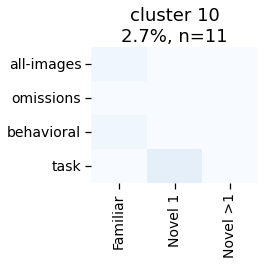

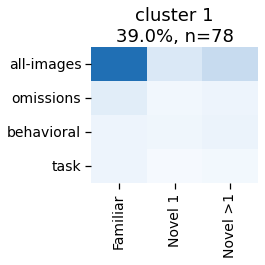

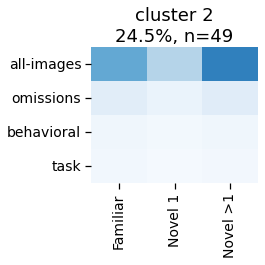

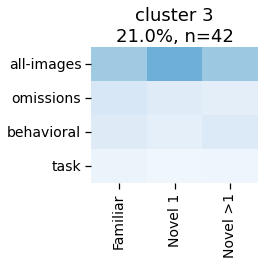

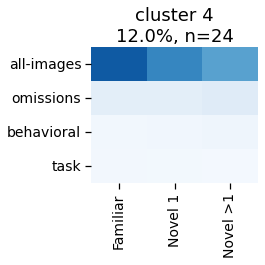

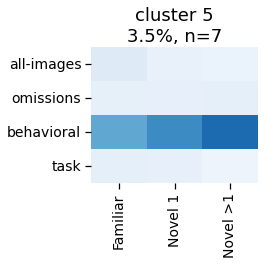

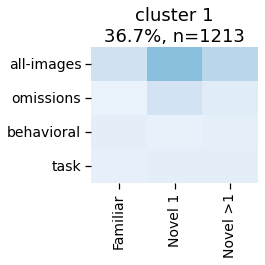

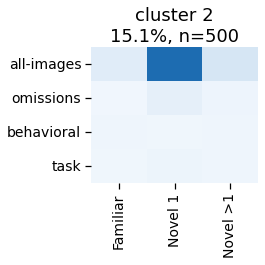

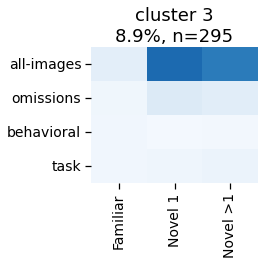

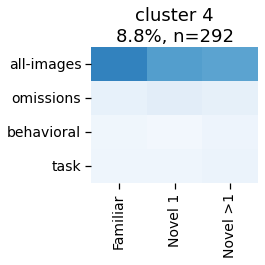

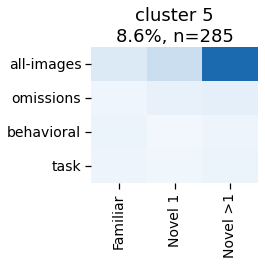

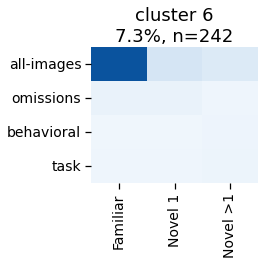

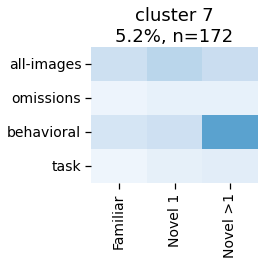

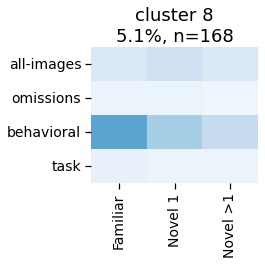

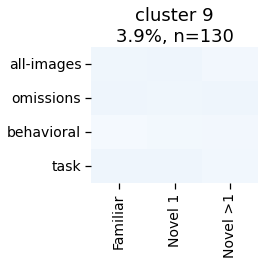

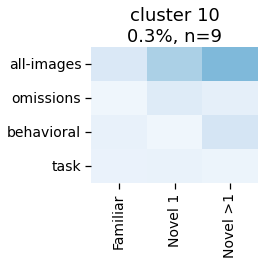

In [26]:
plotting.plot_dropout_heatmaps_and_save_to_cell_examples_folders(cluster_meta, feature_matrix, save_dir)

### plot average dropouts for each cre line in cluster size order

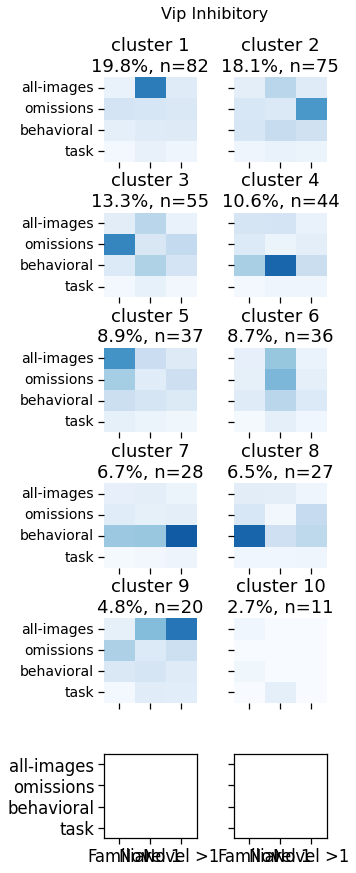

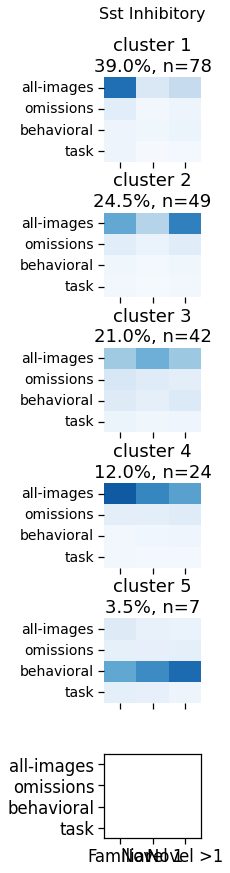

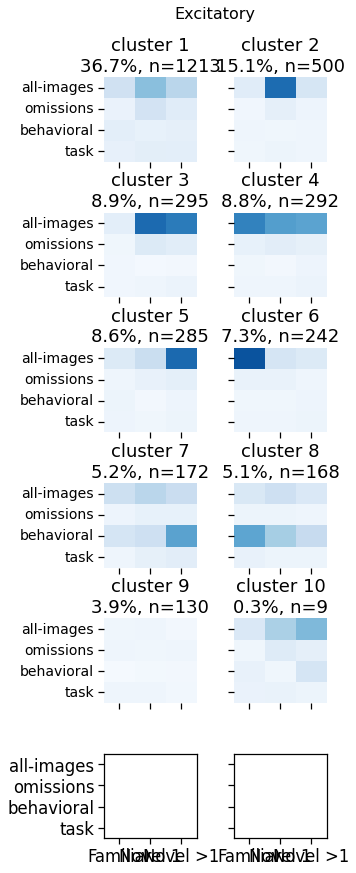

In [27]:
sort_col = 'cluster_id'

plotting.plot_dropout_heatmaps_for_clusters(cluster_meta, feature_matrix, sort_col=sort_col, save_dir=base_dir, folder=folder)

### plot dropout heatmaps in manually sorted order

### plot feature matrix sorted by cluster ID

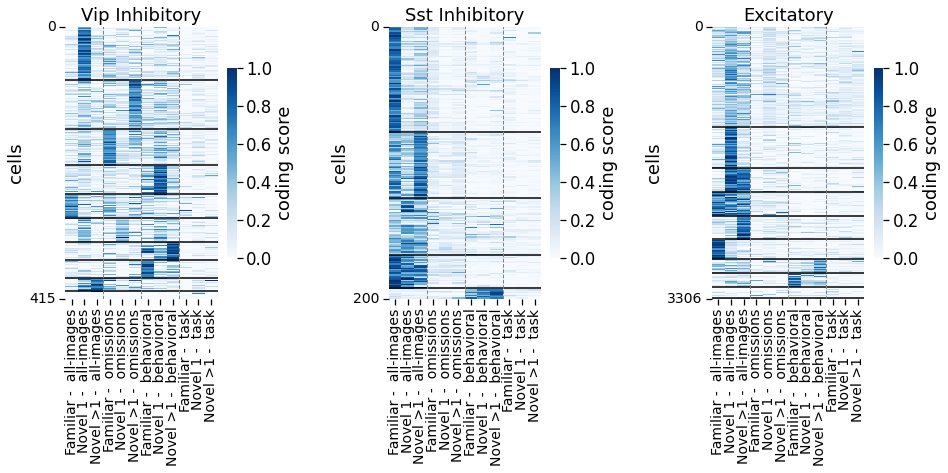

In [28]:
plotting.plot_feature_matrix_sorted(feature_matrix, cluster_meta, sort_col='cluster_id', save_dir=save_dir, folder=folder)
    

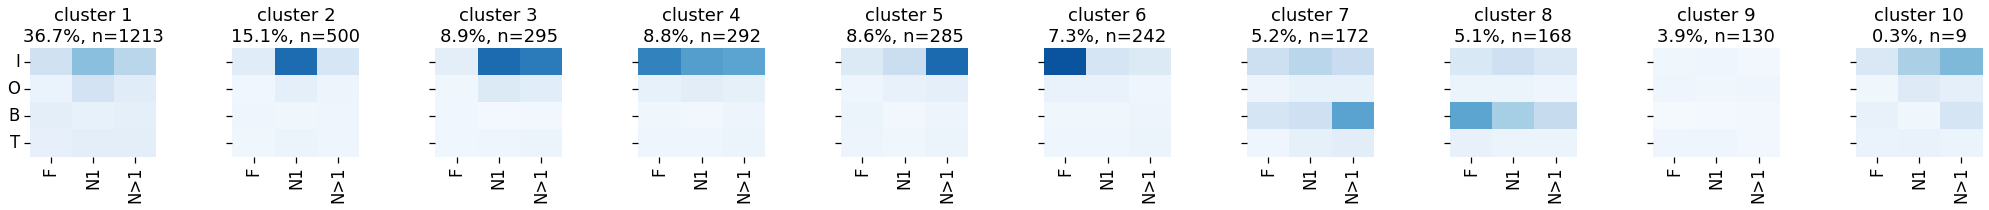

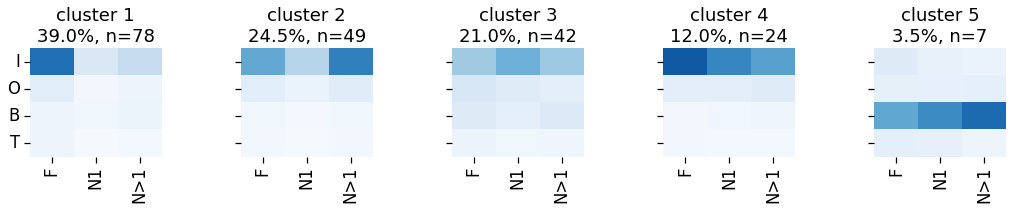

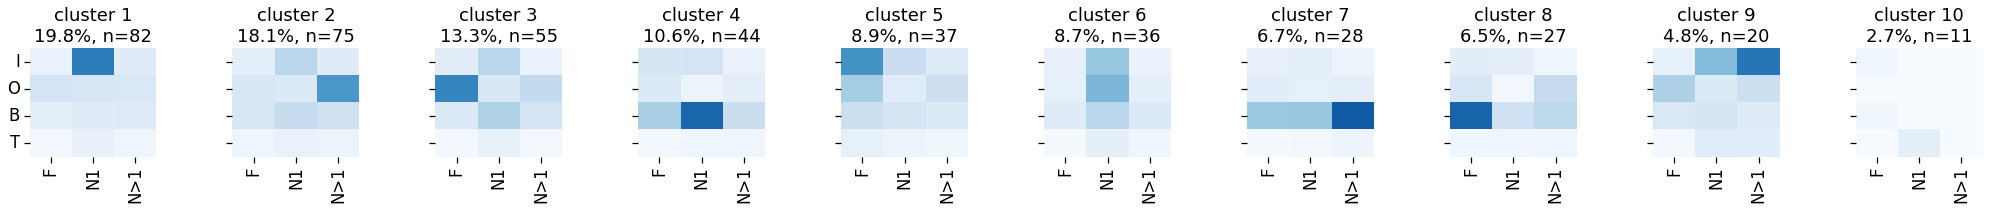

In [29]:
# plot original clusters
feature_matrix = feature_matrix.abs()
sort_order = {}
for cre_line in cre_lines:
    cre_ids = cluster_meta[cluster_meta.cre_line==cre_line].index.values
    cre_tmp = feature_matrix.loc[cre_ids]
    cluster_df = cluster_meta[cluster_meta.cre_line==cre_line]
    sort_order[cre_line] = vba_clust.get_sorted_cluster_ids(cluster_df)
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix=f'_{n_clusters_cre[cre_line]}',
                                )


### Correlations within clusters

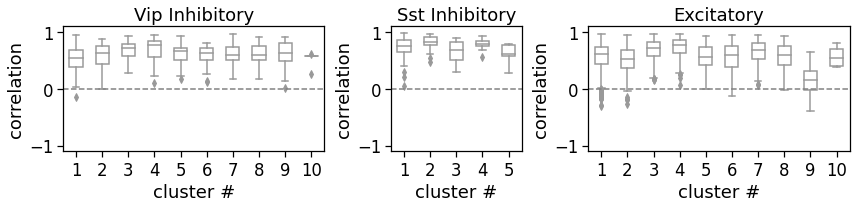

In [30]:
plotting.plot_within_cluster_correlations_all_cre(cluster_meta, n_clusters_cre, sort_order=None, save_dir=base_dir, folder=folder)

In [31]:
feature_matrix.stack()

all-images  behavioral  omissions      task
cell_specimen_id experience_level                                             
1086489847       Familiar            0.004670    0.370910   0.042185  0.002495
                 Novel 1             0.036437    0.031435   0.012834  0.002662
                 Novel >1            0.001467    1.000000   0.028176  0.006705
1086489860       Familiar            0.000000    0.000000   0.000000  0.000000
                 Novel 1             0.813781    0.000000   0.195218  0.231648
...                                       ...         ...        ...       ...
1120133515       Novel 1             1.000000    0.000000   0.000000  0.000000
                 Novel >1            0.353846    0.124006   0.082624  0.000000
1120133649       Familiar            0.375428    0.066043   0.000000  0.000000
                 Novel 1             0.444467    0.451535   0.423097  0.025360
                 Novel >1            0.209440    0.570001   0.000000  0.031117

[11763 rows x 4 columns]

### average dropouts per cre line

KeyError: 'experience_level'

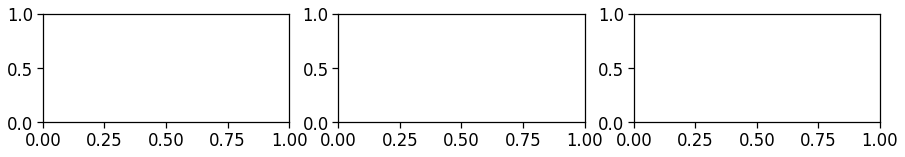

In [32]:
plotting.plot_average_dropout_heatmap_for_cre_lines(feature_matrix.stack(), cluster_meta, save_dir=save_dir, folder=folder)

### plot 100 cells per cluster to examine within cluster variability

Note: this takes a while

In [ ]:
plotting.plot_random_subset_of_cells_per_cluster(cluster_meta, dropouts, save_dir)

In [ ]:
label = 'fraction of cells'
plotting.plot_fraction_cells_by_area_depth(cluster_meta, n_clusters_cre, normalize=True, label=label, 
                                           save_dir=base_dir, folder=folder)

In [ ]:
label = '# of cells'
plotting.plot_fraction_cells_by_area_depth(cluster_meta, n_clusters_cre, normalize=False, label=label, 
                                           save_dir=base_dir, folder=folder)

### population average trace

In [ ]:
# load dataframe with response traces
df_name = 'omission_response_df'
conditions = ['cell_specimen_id', 'omitted']

data_type = 'events'
event_type = 'omissions'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'


multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)
print(len(multi_session_df.ophys_experiment_id.unique()))

In [ ]:
cluster_mdf = multi_session_df.merge(cluster_meta[['cluster_id']], 
                                     on='cell_specimen_id', how = 'inner')

In [ ]:
plotting.plot_population_average_response_for_cluster(cluster_mdf, cre_line, cluster_id, change=False, omitted=True, ax=None)